In [210]:
import pandas as pd
import re
import numpy as np
import seaborn as sns

# Read the CSV file
cafexprod_raw = pd.read_csv("cafexprod_resp.csv")

# View the first 5 rows
cafexprod_raw.head()


,Data,Idade,Atividade,Genero,Bebidas,Frequencia,Horarios,Foco Antes,Foco Depois,Percepcao Positiva,Explicativa,Duracao
0,04/05/2025 14:21:02,23,Apenas estudo,Masculino,"Café, Energéticos (Ex: Red Bull, Monster, etc....",Ocasionalmente (3–4 vezes por semana),"Tarde (12h–18h), Noite (18h–22h)",Baixo,Alto,"Sim, na maioria das vezes",NaN,3.0
1,04/05/2025 14:22:26,21,Estudo e trabalho,Masculino,"Café, Energéticos (Ex: Red Bull, Monster, etc....",Frequentemente (diariamente),"Manhã (6h–12h), Tarde (12h–18h)",Médio,Alto,"Sim, na maioria das vezes",NaN,2.0
2,04/05/2025 14:28:18,47,Apenas trabalho,Feminino,Café,Várias vezes ao dia,"Manhã (6h–12h), Tarde (12h–18h)",Médio,Alto,"Sim, na maioria das vezes",NaN,2.0
3,04/05/2025 14:28:38,20,Apenas estudo,Feminino,"Chá preto/vermelho, Chá verde/mate, Energético...",Ocasionalmente (3–4 vezes por semana),Tarde (12h–18h),Médio,Alto,"Sim, na maioria das vezes",NaN,3.0
4,04/05/2025 14:30:27,52,Apenas trabalho,Coca Zero,"Café, Coca Zero",Frequentemente (diariamente),Manhã (6h–12h),Muito baixo,Alto,"Sim, sempre",Ajuda pq me faz acordar e fico mais ativa,1.0


In [211]:

from abc import ABC, abstractmethod

class LabelEncoder(ABC):
    @abstractmethod
    def encode(self, column):
        pass
    
    @abstractmethod
    def decode(self, column):
        pass

class BasicLabelEncoder(LabelEncoder):
    def __init__(self, dicto):
        super().__init__()
        self.dicto = dicto
        self.dicto["Outro"] = -1
        self.dictorev = {v: k for k, v in dicto.items()}
        
    def encode(self, column):
        return column.map(self.dicto).fillna(-1)

    def decode(self, column):
        return column.map(self.dictorev)
    
class ListLabelEncoder(LabelEncoder):
    def __init__(self, dicto):
        super().__init__()
        self.dicto = dicto
        self.dicto["Outro"] = -1
        self.dictorev = {v: k for k, v in dicto.items()}
        
    def mapear(self, texto):
        texto_limpo = re.sub(r'\s*\(.*?\)\s*', '', texto)
        itens = [item.strip() for item in texto_limpo.split(',')]
        return [self.dicto.get(item, -1) for item in itens]
    
    def desmapear(self, lista_codigos):
        return ', '.join([self.dictorev.get(codigo, 'Outro') for codigo in lista_codigos])
        
    def encode(self, column):
        return column.apply(self.mapear)

    def decode(self, column):
        return column.apply(self.desmapear)

In [212]:
class AtividadeEncoder(BasicLabelEncoder):
    def __init__(self):
        super().__init__({
            "Apenas estudo": 0,
            "Apenas trabalho": 1,
            "Estudo e trabalho": 2,
            "Nenhum dos dois": 3
        })
        
class GeneroEncoder(BasicLabelEncoder):
    def __init__(self):
        super().__init__({
            "Feminino": 0,
            "Masculino": 1,
            "Prefiro não responder": 2
        })

class BebidasEncoder(ListLabelEncoder):
    def __init__(self):
        super().__init__({
            "Café": 0,
            "Chá preto/vermelho": 1,
            "Chá verde/mate": 2,
            "Energéticos": 3,
            "Refrigerantes": 4,
            "Suplementos com cafeína": 5
        })
        
class FrequenciaEncoder(BasicLabelEncoder):
    def __init__(self):
        super().__init__({
            "Nunca":4,
            "Raramente (1–2 vezes por semana)":3,
            "Ocasionalmente (3–4 vezes por semana)":2,
            "Frequentemente (diariamente)":1,
            "Várias vezes ao dia":0,
        })
        
class HorariosEncoder(ListLabelEncoder):
    def __init__(self):
        super().__init__({
            "Manhã":0,
            "Tarde":1,
            "Noite":2,
            "Madrugada":3
        })
        
class FocoEncoder(BasicLabelEncoder):
    def __init__(self):
        super().__init__({
            "Muito baixo":0,
            "Baixo":1,
            "Médio":2,
            "Alto":3,
            "Muito alto":4,
        })
        
class PercepcaoEncoder(BasicLabelEncoder):
    def __init__(self):
        super().__init__({
            "Sim, sempre": 0,
            "Sim, na maioria das vezes": 1,
            "Depende da situação": 2,
            "Não percebo diferença": 3,
            "Não, atrapalha meu desempenho": 4,
        })
        

In [213]:
encoders = [("Atividade", AtividadeEncoder()),
            ("Genero", GeneroEncoder()),
            ("Bebidas", BebidasEncoder()),
            ("Frequencia", FrequenciaEncoder()),
            ("Horarios", HorariosEncoder()),
            ("Foco Antes", FocoEncoder()),
            ("Foco Depois", FocoEncoder()),
            ("Percepcao Positiva", PercepcaoEncoder())
            ]

cafexprod_encoded = cafexprod_raw.copy()

for encoder in encoders:
    cafexprod_encoded[encoder[0]] = encoder[1].encode(cafexprod_raw[encoder[0]])
    
cafexprod_encoded.head()

,Data,Idade,Atividade,Genero,Bebidas,Frequencia,Horarios,Foco Antes,Foco Depois,Percepcao Positiva,Explicativa,Duracao
0,04/05/2025 14:21:02,23,0,1.0,"[0, 3, 4]",2,"[1, 2]",1,3,1,NaN,3.0
1,04/05/2025 14:22:26,21,2,1.0,"[0, 3, 4]",1,"[0, 1]",2,3,1,NaN,2.0
2,04/05/2025 14:28:18,47,1,0.0,[0],0,"[0, 1]",2,3,1,NaN,2.0
3,04/05/2025 14:28:38,20,0,0.0,"[1, 2, 3]",2,[1],2,3,1,NaN,3.0
4,04/05/2025 14:30:27,52,1,-1.0,"[0, -1]",1,[0],0,3,0,Ajuda pq me faz acordar e fico mais ativa,1.0


In [ ]:

def estat_quanti(column):
    media = column.mean()
    mediana = column.median()
    moda = column.mode().tolist()
    return (media, mediana, moda)
    
def frequencias(column, encoder:ListLabelEncoder=None):
    freq_abs = column.value_counts().sort_index()
    freq_rel = (column.value_counts(normalize=True).sort_index()*100).round(2)
    freq_acum = freq_rel.cumsum()
    
    frequencias = pd.DataFrame({
        "Item": [encoder.dictorev.get(i, "Desconhecido") for i in freq_abs.index] if encoder != None else freq_abs.index,
        "Frequência Absoluta": freq_abs.values,
        "Frequência Relativa (%)": freq_rel.values,
        "Frequência Acumulada (%)": freq_acum.values
    })
    
    return frequencias.reset_index(drop=True)

def frequencias_lista(column, encoder:ListLabelEncoder):
    todos_cod = column.explode()
    freq_abs = todos_cod.value_counts().sort_index()
    freq_relativa = (freq_abs / freq_abs.sum() * 100).round(2)
    freq_acum = freq_relativa.cumsum()
    
    frequencias = pd.DataFrame({
        "Item": [encoder.dictorev.get(i, "Desconhecido") for i in freq_abs.index],
        "Frequência Absoluta": freq_abs.values,
        "Frequência Relativa (%)": freq_relativa.values,
        "Frequência Acumulada (%)": freq_acum.values
    })
    
    return frequencias.reset_index(drop=True)

def entropia(column):
    p = column.value_counts(normalize=True).sort_index().values
    return -np.sum(p * np.log2(p))
    
import matplotlib.pyplot as plt

def histograma(column, titulo, xlabel,ylabel):
    plt.figure(figsize=(8, 5))
    plt.hist(column, bins=range(column.min(), column.max() + 1, 1), edgecolor='black', color='#69b3a2')

    # Títulos e rótulos
    plt.title(titulo, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
def grafico_pizza(column, titulo, encoder:LabelEncoder):    
    cont = encoder.decode(column).value_counts().sort_index()
    # Gerar gráfico de pizza
    plt.figure(figsize=(6, 6))
    plt.pie(cont,labels=cont.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)

    plt.title(titulo)
    plt.axis('equal')  # manter proporção de círculo
    plt.show()
    
def plotar_barras_selecoes(coluna, encoder:ListLabelEncoder, title, labelX, labelY):
    # Explode as listas para uma série plana com os códigos
    todos_codigos = coluna.explode()

    # Contagem de seleções por código
    contagem = todos_codigos.value_counts().sort_index()

    # Transformar para DataFrame para plotagem
    selecoes_df = pd.DataFrame({
        labelX: [encoder.dictorev.get(i, "Desconhecido") for i in contagem.index],
        labelY: contagem.values
    })

    # Plotagem
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=selecoes_df, x=labelX, y=labelY)
    

    plt.title(title, fontsize=14)
    plt.xlabel(labelX)
    plt.ylabel(labelY)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

42.85526315789474 43.0 [21, 52]
5.2836615592969505
       Item  Frequência Absoluta  Frequência Relativa (%)  \
0  [10, 20)                    7                     9.21   
1  [20, 30)                   15                    19.74   
2  [30, 40)                   10                    13.16   
3  [40, 50)                   15                    19.74   
4  [50, 60)                   15                    19.74   
5  [60, 70)                    7                     9.21   
6  [70, 80)                    5                     6.58   
7  [80, 90)                    2                     2.63   

   Frequência Acumulada (%)  
0                      9.21  
1                     28.95  
2                     42.11  
3                     61.85  
4                     81.59  
5                     90.80  
6                     97.38  
7                    100.01  


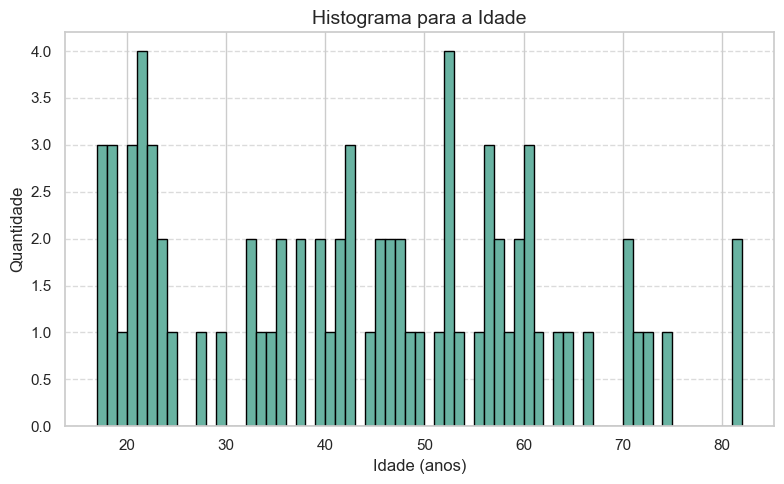

In [215]:
#Idade 
coluna_idade = cafexprod_encoded["Idade"]
idade_med, idade_mediana, idade_moda = estat_quanti(coluna_idade)
print(idade_med, idade_mediana, idade_moda)
print(entropia(coluna_idade))

idade_min = coluna_idade.min()
idade_max = coluna_idade.max()
bins = range((idade_min // 10) * 10, ((idade_max // 10) + 2) * 10, 10)

# Criar categorias (faixas de idade)
faixas = pd.cut(coluna_idade, bins=bins, right=False)

print(frequencias(faixas))

histograma(coluna_idade, "Histograma para a Idade", "Idade (anos)", "Quantidade")

[1]


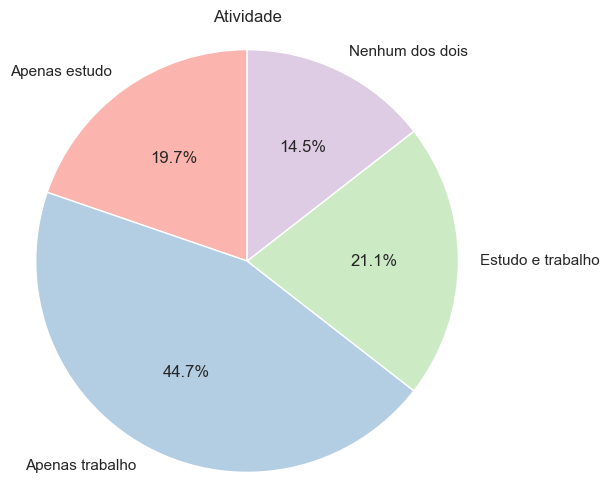

In [216]:
#Atividade
_, _, atv_moda = estat_quanti(cafexprod_encoded["Atividade"])
print(atv_moda)
grafico_pizza(cafexprod_encoded["Atividade"],"Atividade", AtividadeEncoder())

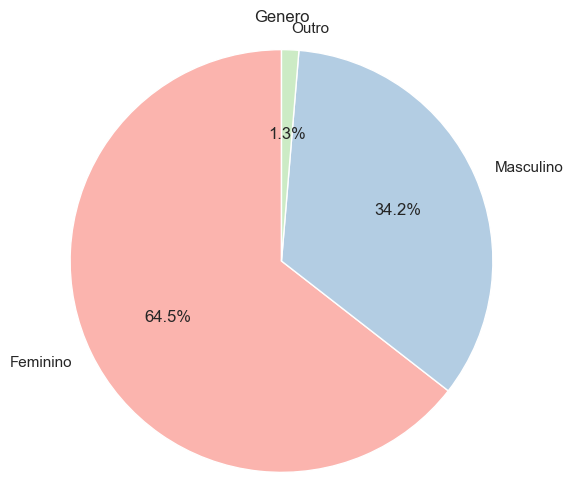

In [217]:
#Genero
grafico_pizza(cafexprod_encoded["Genero"], "Genero", GeneroEncoder())

(np.float64(1.9090909090909092), np.float64(2.0), [0])
                      Item  Frequência Absoluta  Frequência Relativa (%)  \
0                    Outro                    1                     0.70   
1                     Café                   61                    42.66   
2       Chá preto/vermelho                    4                     2.80   
3           Chá verde/mate                   12                     8.39   
4              Energéticos                   19                    13.29   
5            Refrigerantes                   41                    28.67   
6  Suplementos com cafeína                    5                     3.50   

   Frequência Acumulada (%)  
0                      0.70  
1                     43.36  
2                     46.16  
3                     54.55  
4                     67.84  
5                     96.51  
6                    100.01  


C:\Users\lucia\AppData\Local\Temp\ipykernel_22468\1978113706.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=selecoes_df, x=labelX, y=labelY, palette="crest")


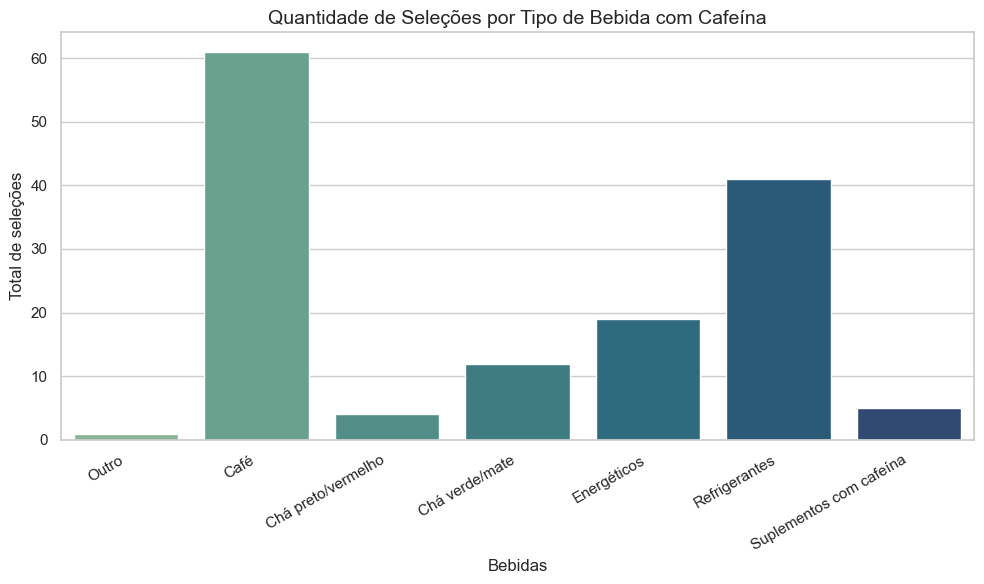

In [218]:
#Bebidas
print(estat_quanti(cafexprod_encoded["Bebidas"].explode()))
print(frequencias_lista(cafexprod_encoded["Bebidas"], BebidasEncoder()))

plotar_barras_selecoes(cafexprod_encoded["Bebidas"], BebidasEncoder(), "Quantidade de Seleções por Tipo de Bebida com Cafeína", "Bebidas", "Total de seleções")


(np.float64(1.1842105263157894), np.float64(1.0), [1])
                                    Item  Frequência Absoluta  \
0                    Várias vezes ao dia                   16   
1           Frequentemente (diariamente)                   43   
2  Ocasionalmente (3–4 vezes por semana)                    4   
3       Raramente (1–2 vezes por semana)                   13   

   Frequência Relativa (%)  Frequência Acumulada (%)  
0                    21.05                     21.05  
1                    56.58                     77.63  
2                     5.26                     82.89  
3                    17.11                    100.00  


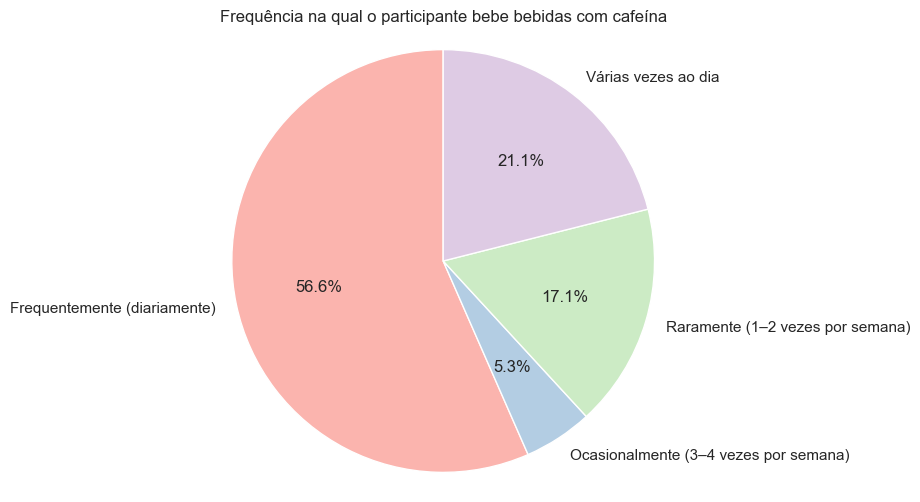

In [219]:
# Frequencia
print(estat_quanti(cafexprod_encoded["Frequencia"]))
print(frequencias(cafexprod_encoded["Frequencia"], FrequenciaEncoder()))

grafico_pizza(cafexprod_encoded["Frequencia"], "Frequência na qual o participante bebe bebidas com cafeína", FrequenciaEncoder())

(np.float64(0.6721311475409836), np.float64(0.5), [0])


C:\Users\lucia\AppData\Local\Temp\ipykernel_22468\1978113706.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=selecoes_df, x=labelX, y=labelY, palette="crest")


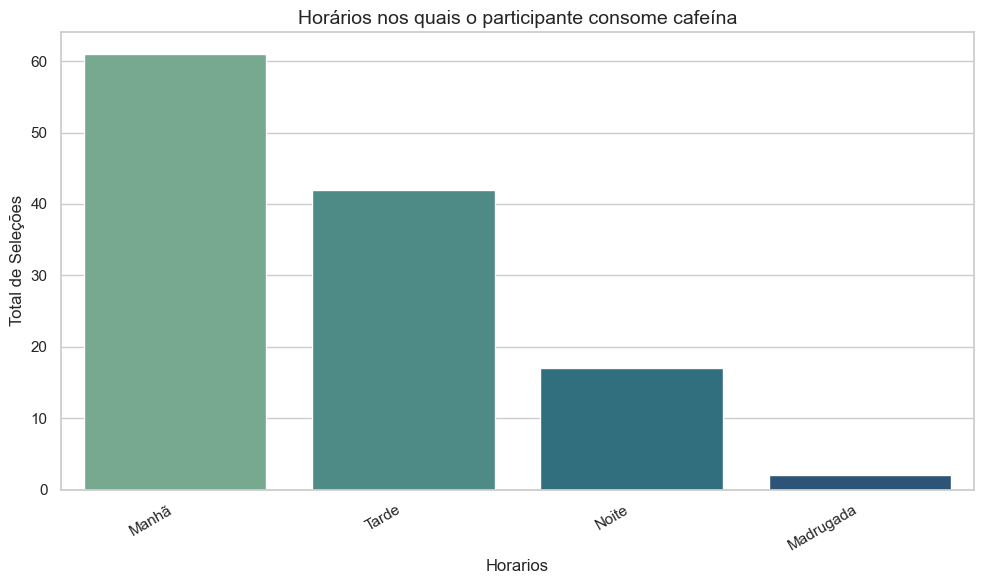

In [220]:
# Em quais horários você costuma consumir cafeína? 
print(estat_quanti(cafexprod_encoded["Horarios"].explode()))
plotar_barras_selecoes(cafexprod_encoded["Horarios"], HorariosEncoder(), "Horários nos quais o participante consome cafeína", "Horarios", "Total de Seleções")

(np.float64(1.855263157894737), np.float64(2.0), [2])


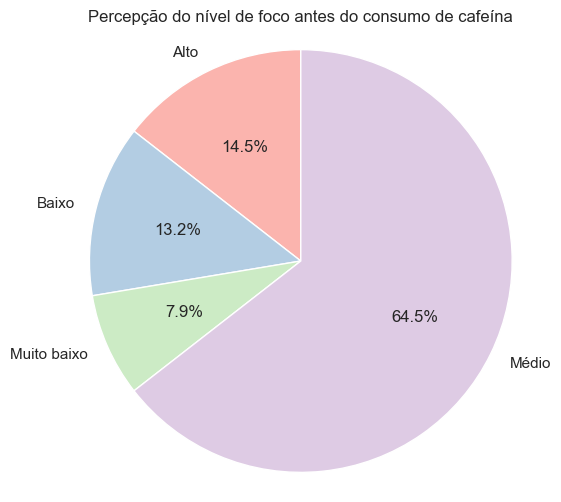

In [221]:
# Como você avalia seu nível de foco e produtividade antes de consumir cafeína? 
print(estat_quanti(cafexprod_encoded["Foco Antes"]))
grafico_pizza(cafexprod_encoded["Foco Antes"], "Percepção do nível de foco antes do consumo de cafeína", FocoEncoder())

(np.float64(2.526315789473684), np.float64(3.0), [3])


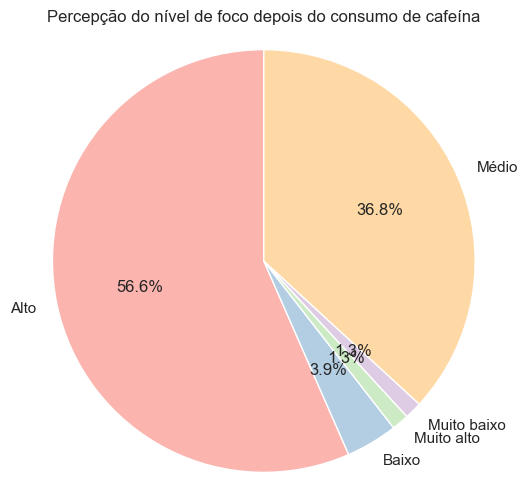

In [222]:
# Como você avalia seu nível de foco e produtividade depois de consumir cafeína? 
print(estat_quanti(cafexprod_encoded["Foco Depois"]))
grafico_pizza(cafexprod_encoded["Foco Depois"], "Percepção do nível de foco depois do consumo de cafeína", FocoEncoder())


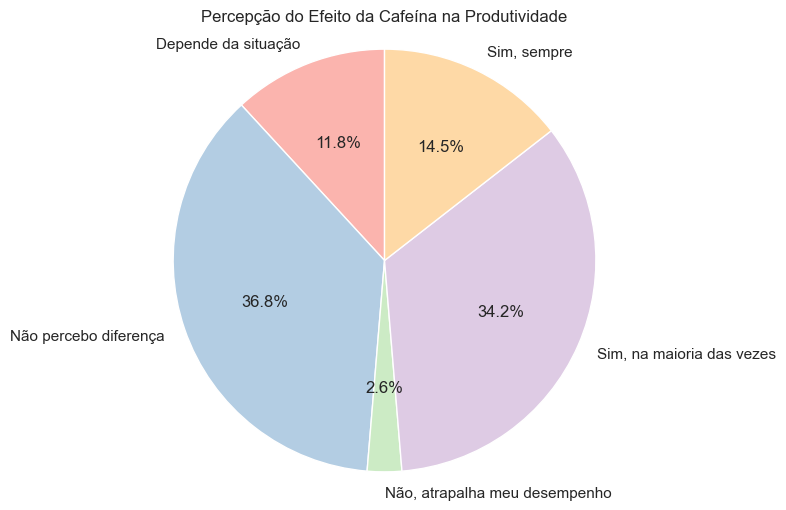

In [223]:
#  Você acredita que a cafeína tem um efeito positivo na sua produtividade? 

grafico_pizza(cafexprod_encoded["Percepcao Positiva"], "Percepção do Efeito da Cafeína na Produtividade", PercepcaoEncoder())